In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import timeit

In [ ]:
# Load dataset in batch sizes
train_rawdata, test_rawdata = tfds.load('genomics_ood', split=['train[:80%]', 'train[20%:]'], as_supervised=True)

In [ ]:
# Only take a sample of the whole dataset
train_rawdata = train_rawdata.take(100000)
test_rawdata = test_rawdata.take(1000)

In [ ]:
def onehotify(tensor):
    # Function to one hotify the genome string sequence to a one hot vector
    vocab = {'A':'1','C':'2','G':'3','T':'0'}
    for key in vocab.keys():
        tensor = tf.strings.regex_replace(tensor, key, vocab[key])
    split = tf.strings.bytes_split(tensor)
    labels = tf.cast(tf.strings.to_number(split), tf.uint8)
    onehot = tf.one_hot(labels, 4)
    onehot = tf.reshape(onehot, (-1,))
    return onehot

In [ ]:
# Map to onehotvectors
train_ds = train_rawdata.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))
test_ds = test_rawdata.map(lambda x, y: (onehotify(x), tf.one_hot(y, 10)))

# Batch data
train_ds = train_ds.batch(256)
test_ds = test_ds.batch(128)

# Shuffle data
train_ds = train_ds.shuffle(buffer_size=256)
test_ds = test_ds.shuffle(buffer_size=128)

# Prefetch data
train_ds = train_ds.prefetch(128)
test_ds = test_ds.prefetch(128)

In [ ]:
len(test_ds)

8

##2. Model
We will implement a simple fully connected feed forward neural network like the lasttime.  Our network will have the following layers:•Hidden layer 1:  256 units.  With sigmoid activation function.•Hidden layer 2:  256 units.  With sigmoid activation function.•Output:  10 units.  With softmax activation function.Instead of implementing our own layer we directly implement the network using pre-built layers from TensorFlow (keras)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Layer

class Model(Model):

    def __init__(self):
        super(Model, self).__init__()

        self.hidden_layer_1 = tf.keras.layers.Dense(units=256,
                                                    activation=tf.keras.activations.sigmoid
                                                    )

        self.hidden_layer_2 = tf.keras.layers.Dense(units=256,
                                                    activation=tf.keras.activations.sigmoid
                                                    )

        self.output_layer = tf.keras.layers.Dense(units=10,
                                                  activation=tf.keras.activations.softmax
                                                  )
    
    def call(self, x):
        # Forwardstep
        x = self.hidden_layer_1(x)
        x = self.hidden_layer_2(x)
        x = self.output_layer(x)
        return x

## Helper Functions

In [ ]:
def train_step(model, input, target, loss_function, optimizer):
    # loss_object and optimizer_object are instances of respective tensorflow classes
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
        gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss 

def test(model, test_data, loss_function):
    # test over complete test data

    test_accuracy_aggregator = []
    test_loss_aggregator = []

    for (input, target) in test_data:
        #print("input shape", input.shape)
        #print("targetshape: ", target.shape)
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy =  np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = np.mean(test_loss_aggregator)
    test_accuracy = np.mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

## 3. Training
Then train your network for 10 epochs using a learning rate of 0.1.

As a loss use the categorical cross entropy. As an optimizer use SGD.

For the training loop you can use the MNIST notebook on Courseware as an orientation to try to build one yourself. You can, but you don’t have to, compute the loss of eachstep with the running average, as we did it in the MNIST notebook. For this task, an accuracy of 35 - 40% is sufficient.

In [ ]:
tf.keras.backend.clear_session()

### Hyperparameters
num_epochs = 10
learning_rate = 0.1
running_average_factor = 0.95

# Initialize the model.
model = Model()
# Initialize the loss: categorical cross entropy. Check out 'tf.keras.losses'.
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
# Initialize the optimizer: Adam with default parameters. Check out 'tf.keras.optimizers'
optimizer = tf.keras.optimizers.SGD(learning_rate)

# Initialize lists for later visualization.
train_losses = []

test_losses = []
test_accuracies = []

# Testing once before we begin
test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

# Check how model performs on train data once before we begin
train_loss, _ = test(model, train_ds, cross_entropy_loss)
train_losses.append(train_loss)

# Time the training
start = timeit.timeit()

# We train for num_epochs epochs.
for epoch in range(num_epochs):
    print('Epoch: __ ' + str(epoch))

    train_dataset = train_ds.shuffle(buffer_size=128)
    test_dataset = test_ds.shuffle(buffer_size=128)

    #training (and checking in with training)
    running_average = 0
    for (input,target) in train_ds:
        train_loss = train_step(model, input, target, cross_entropy_loss, optimizer)
        running_average = running_average_factor * running_average  + (1 - running_average_factor) * train_loss
    train_losses.append(running_average)

    #testing
    test_loss, test_accuracy = test(model, test_ds, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

duration = timeit.timeit() - start

print('The training took ', str(int(duration / 60)), ' minutes and ', str(duration % 60), ' seconds.' )

Epoch: __ 0
Epoch: __ 1
Epoch: __ 2
Epoch: __ 3
Epoch: __ 4
Epoch: __ 5
Epoch: __ 6
Epoch: __ 7
Epoch: __ 8
Epoch: __ 9


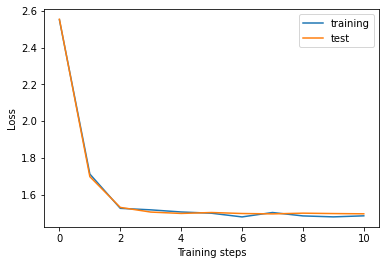

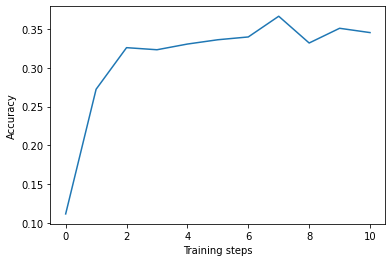

In [ ]:
# Visualize accuracy and loss for training and test data. 
# One plot training and test loss.
# One plot training and test accuracy.
plt.figure()
line1, = plt.plot(train_losses)
line2, = plt.plot(test_losses)
plt.xlabel("Training steps")
plt.ylabel("Loss")
plt.legend((line1,line2),("training","test"))
plt.show()

plt.figure()
line1, = plt.plot(test_accuracies)
plt.xlabel("Training steps")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
# Save the weights (or not the accuracy is not presentable)
model.save_weights('genomics_ood-.35.h5')